# Features that affect Loan Yield
## by Anitha Thanam

## Investigation Overview

I would like to find the features that affects the yield/return/loss (LenderYield and EstimatedLoss) for a loan, so that for a new loan we should be able to predict if that would be profitable/risky. 
Main features will be looking at are 
#### Numeric variables

    CreditScoreRangeUpper
    DebtToIncomeRatio
    Investors

##### Categorical variables

    CreditGrade
    ProsperScore
    ListingCategory
    EmploymentStatus
    IsBorrowerHomeowner
    IncomeRange



## Dataset Overview

The data consists information about 113K loans with 81 features describing about the loan and the borrower.
- Credit Rating for rows prior to 2009 are in CreditGrade column and post july 2009 are in 'ProsperRating (Alpha)'. So, both columns were combined into one
- About 133 rows has an invalid Credit Score, so these we not considered during the plot
- Features having Nan values are ignored during the plot
    

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
file_name = 'C:\Learning\DataAnalyst\prosperLoanData.csv'
with open(file_name) as f:
    file_encoding = f.encoding

df = pd.read_csv(file_name, encoding = file_encoding)

In [3]:
# Data Wrangling
# Convert ListingCreationDate to datetime data type
df.ListingCreationDate = pd.to_datetime(df.ListingCreationDate)

# Credit Rating for rows prior to 2009 are in CreditGrade column and post july 2009 are in 'ProsperRating (Alpha)'
df['CreditRating'] = df.CreditGrade.fillna(df['ProsperRating (Alpha)'])

# convert the credit grade column into an ordered categorical data type  
grade_sort = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']
ordered_grade = pd.api.types.CategoricalDtype(ordered = True, categories = grade_sort)
df['CreditRating'] = df.CreditRating.astype(ordered_grade)

# convert the IncomeRange column into an ordered categorical data type
OrderedIncomeRange = ['Not displayed','Not employed','$0', '$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']
OrderedIncomeRange = pd.api.types.CategoricalDtype(ordered = True, categories = OrderedIncomeRange)
df['OrderedIncomeRange'] = df.IncomeRange.astype(OrderedIncomeRange)

## Distribution for Lender Yield

Lender Yield takes value between -0.01 and 0.49 and its distribution is unimodel with 0.14 as its center and has  exception of a peak at the bin '0.30 - 0.31'

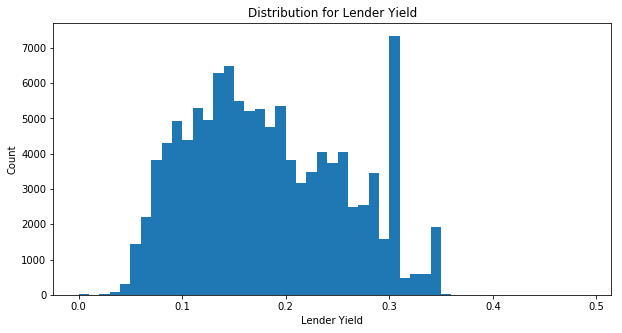

In [4]:
plt.figure(figsize = [10, 5])
bin_edges = np.arange(0, df.LenderYield.max() + 0.0001, 0.01)
sb.distplot(df.LenderYield, bins = bin_edges, kde = False, hist_kws = {'alpha' : 1})
plt.title('Distribution for Lender Yield')
plt.xlabel('Lender Yield')
plt.ylabel('Count');

## Distribution of Investors

About 24.41% of the borrowers are investing on their own and the distribution for the rest is highly skewed on the left. So, Log transformation is done for Investors with value more than 1 and the distribution is found to be unimodel with 2 as the center which close to 100 investors.

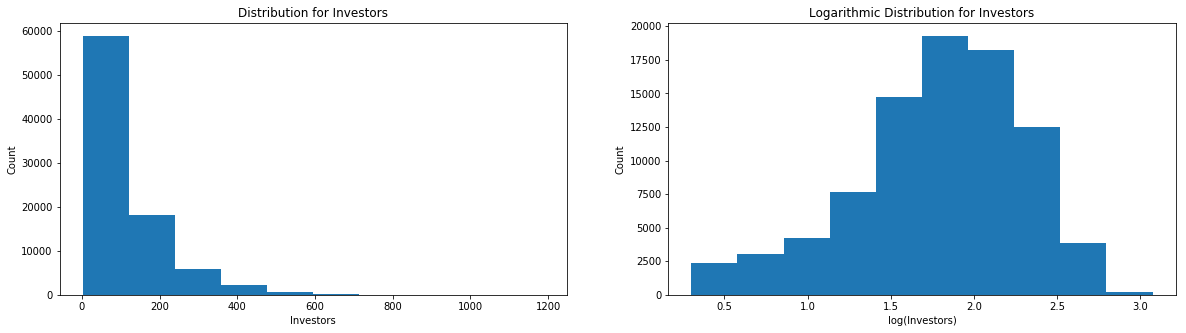

In [5]:
plt.figure(figsize = [20, 5])
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
plt.hist(df[(df.Investors.isna() == False) & (df.Investors != 1)].Investors)
plt.title('Distribution for Investors')
plt.xlabel('Investors')
plt.ylabel('Count')

# In the above plot, the data is highly skewed
# So, applying a logarithmic transform, the data will follow a normal distribution
plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
plt.hist(np.log10(df[(df.Investors.isna() == False) & (df.Investors != 1)].Investors))
plt.title('Logarithmic Distribution for Investors')
plt.xlabel('log(Investors)')
plt.ylabel('Count');

## Credit Rating vs Lender Yield/Estimated Loss 

From the above plot, we could see that the yield is higher for high risk credit rating and the estimated loss is high as well for low credit score and vice versa. We could also see that there are more outliers with lower yield for 'HR' and higher yield for 'AA'. And there are outliers for 'HR' with much high loss. 

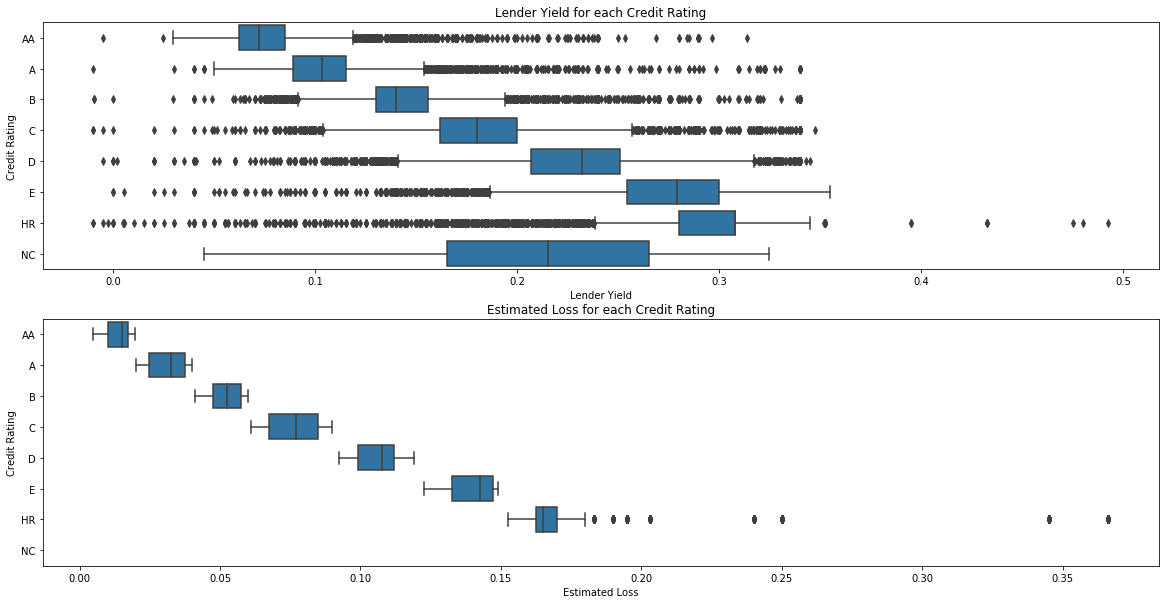

In [6]:
plt.figure(figsize = [20, 10])
plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1
sb.boxplot(data = df, x = 'LenderYield', y = 'CreditRating', color = sb.color_palette()[0])
plt.title('Lender Yield for each Credit Rating')
plt.xlabel('Lender Yield')
plt.ylabel('Credit Rating');

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
sb.boxplot(data = df[df.EstimatedLoss.isna() == False],
           x = 'EstimatedLoss', y = 'CreditRating', color = sb.color_palette()[0])
plt.title('Estimated Loss for each Credit Rating')
plt.xlabel('Estimated Loss')
plt.ylabel('Credit Rating');

## Prosper Score vs Lender Yield/Estimated Loss
Prosper Score is a custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. From the plot above, we could see that when there is a high risk, the yield is more and vice versa. And also, the Estimated Loss is more when the risk is high and vice versa. And regression fitting from the plot suggests the same.

Also, we could see that for Prosper score at 3, 4 and 5, there is more data near 0.3~0.31, which explains the exceptional peak on our very first histogram plot.

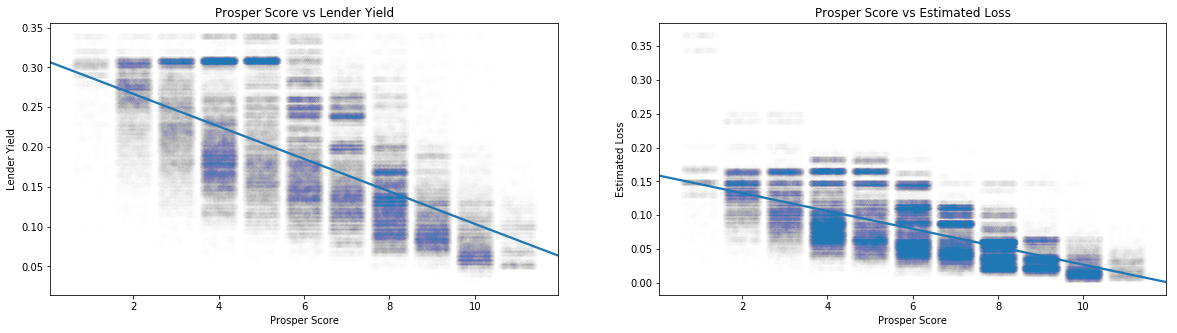

In [7]:
plt.figure(figsize = [20, 5])
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
# scatterplot with regression function fitting
sb.regplot(data = df[df.ProsperScore.isna() == False], 
           x = 'ProsperScore', y = 'LenderYield', scatter_kws={'alpha':0.005}, x_jitter = 0.4)
# apply jitter if there is high amount of overlap in points
plt.title('Prosper Score vs Lender Yield')
plt.xlabel('Prosper Score')
plt.ylabel('Lender Yield')

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
# scatterplot with regression function fitting
sb.regplot(data = df[(df.EstimatedLoss.isna() == False) & (df.ProsperScore.isna() == False)], 
           x = 'ProsperScore', y = 'EstimatedLoss', scatter_kws={'alpha':0.005}, x_jitter = 0.4)
# apply jitter if there is high amount of overlap in points
plt.title('Prosper Score vs Estimated Loss')
plt.xlabel('Prosper Score')
plt.ylabel('Estimated Loss');

## Credit Score vs Lender Yield/Estimated Loss¶
Similar to other plots, the heat map for credit score also suggests the same.

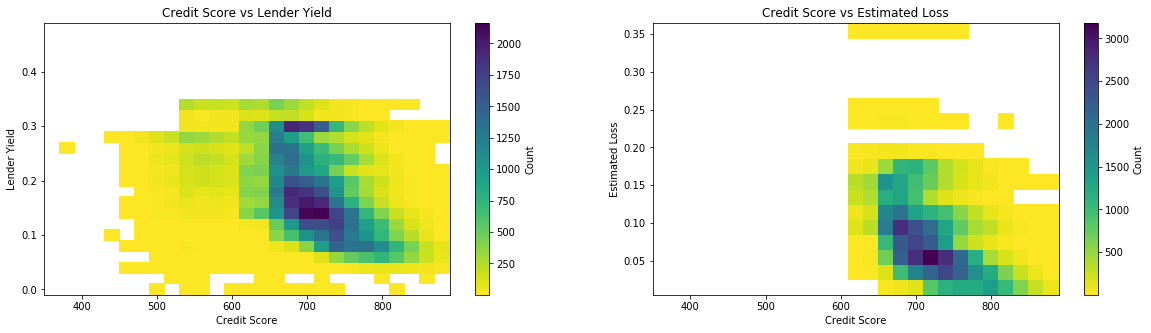

In [8]:
plt.figure(figsize = [20, 5])
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
bins_x = np.arange(350, 900 + 1, 20)
bins_y = np.arange(df.LenderYield.min(), df.LenderYield.max() + 0.001, 0.02)
plt.hist2d(data = df, x = 'CreditScoreRangeUpper', y = 'LenderYield',
           cmap = 'viridis_r', # reversing the default "viridis" color palette
           cmin = 0.5, # cell will only get colored if it contains at least one point
           bins = [bins_x, bins_y]) 
cbar = plt.colorbar()
cbar.set_label('Count')
plt.title('Credit Score vs Lender Yield')
plt.xlabel('Credit Score')
plt.ylabel('Lender Yield')

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
bins_x = np.arange(350, 900 + 1, 20)
bins_y = np.arange(df.EstimatedLoss.min(), df.EstimatedLoss.max() + 0.001, 0.02)
plt.hist2d(data = df, x = 'CreditScoreRangeUpper', y = 'EstimatedLoss',
           cmap = 'viridis_r', # reversing the default "viridis" color palette
           cmin = 0.5, # cell will only get colored if it contains at least one point
           bins = [bins_x, bins_y]) 
cbar = plt.colorbar()
cbar.set_label('Count')
plt.title('Credit Score vs Estimated Loss')
plt.xlabel('Credit Score')
plt.ylabel('Estimated Loss');

## Lender Yield for every Category and Credit Rating
We have already seen the relationship between Credit Rating and Lender Yield in the previous plot. By breaking down to Listing category, we could see that for Personal Loan and Student use the data is distributed bit more than other catergories having less data. For Home improvement, we could see that comparatively it has less outliers in the bottom of the plot, suggesting higher yield with less risk for this category.

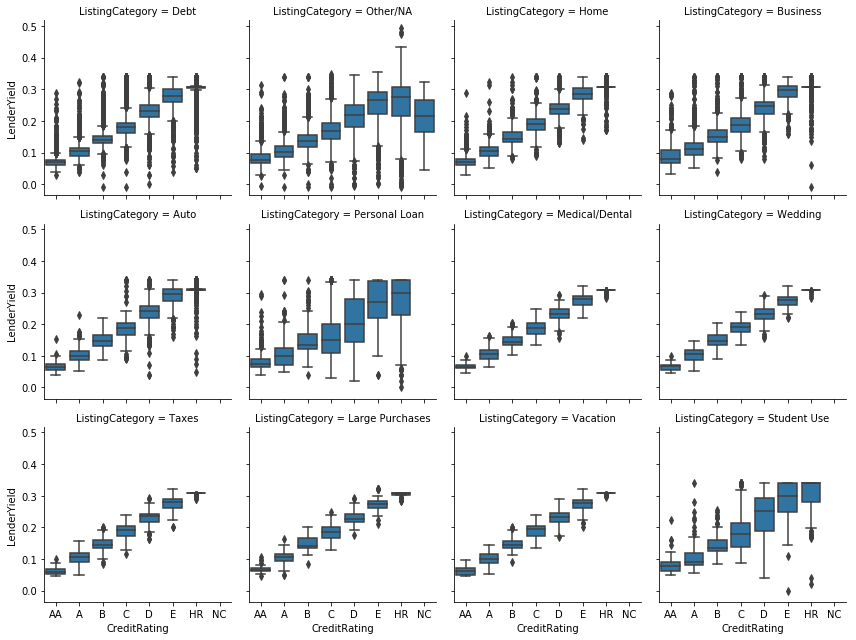

In [9]:
listing = ['Other/NA', 'Debt', 'Home', 'Business', 'Personal Loan', 'Student Use', 'Auto', 'Other/NA', 'Other/NA', 'Auto', 'Other/NA', 'Wedding', 'Other/NA', 'Home', 'Large Purchases', 'Medical/Dental', 'Auto', 'Auto', 'Taxes', 'Vacation', 'Wedding'] 
df['ListingCategory'] = df['ListingCategory (numeric)'].apply(lambda x: listing[x])

g = sb.FacetGrid(data = df[df.ListingCategory.isna() == False], 
                 col = 'ListingCategory', 
                 col_order = df.ListingCategory.value_counts().index,
                 col_wrap = 4, 
                 margin_titles = True)
g.map(sb.boxplot, 'CreditRating', 'LenderYield');

## Timeline
When we look at the monthly mean data, there is a huge increase in the number of loans in 2013. But the Return/Yield trends to go lower in 2013.

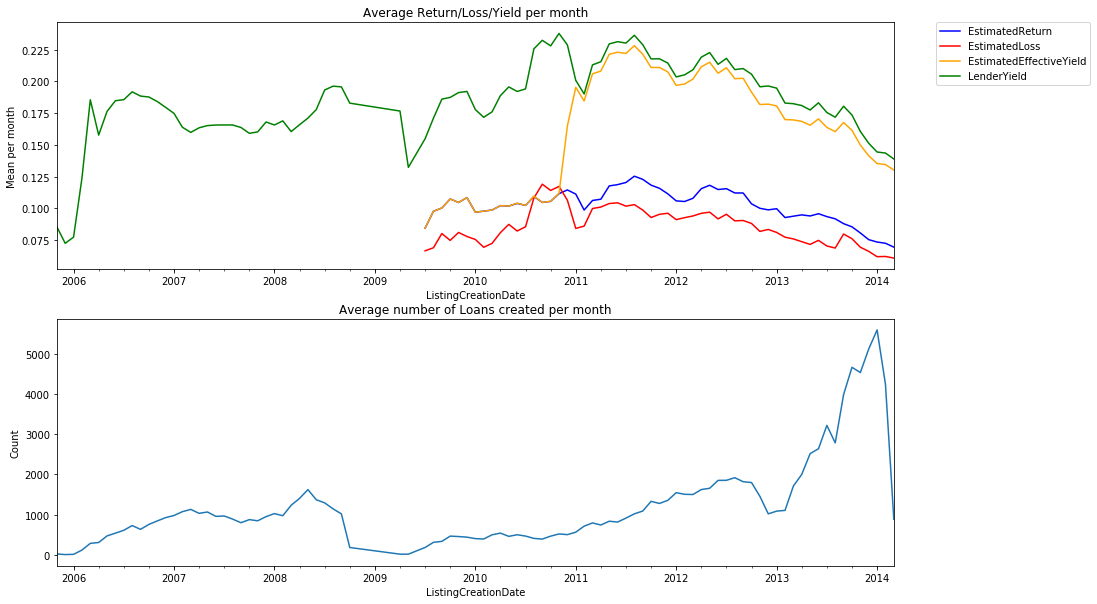

In [10]:
plt.figure(figsize = [15, 10])

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1
monthly = df.ListingCreationDate.dt.to_period("M")

return_per_month = df[df.EstimatedReturn.isna() == False].groupby(monthly).EstimatedReturn.mean() 
loss_per_month = df[df.EstimatedLoss.isna() == False].groupby(monthly).EstimatedLoss.mean() 
yield_per_month = df[df.EstimatedEffectiveYield.isna() == False].groupby(monthly).EstimatedEffectiveYield.mean() 
lender_yield_per_month = df[df.LenderYield.isna() == False].groupby(monthly).LenderYield.mean() 

return_per_month.plot(color = 'blue')
loss_per_month.plot(color = 'red')
yield_per_month.plot(color = 'orange')
lender_yield_per_month.plot(color = 'green')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Mean per month')
plt.title('Average Return/Loss/Yield per month')

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
count_per_month = df.groupby(monthly).ListingKey.count()
count_per_month.plot()
plt.title('Average number of Loans created per month')
plt.ylabel('Count');